<H1>Relationship between IL and price change in a stableswap pool</H1>


In [1]:
import sys
import os
import glob
import random
sys.path.append('../..')

from model import processing
from matplotlib import pyplot as plt

from model import run
from model import plot_utils as pu
from model.amm.omnipool_amm import OmnipoolState, cash_out_omnipool, value_assets, usd_price, lrna_price
from model.amm.stableswap_amm import StableSwapPoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, price_sensitive_trading
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)
# price_list = processing.import_binance_prices(['BTC', 'ETH', 'DOT'], start_date='Jan 1 2023', days = 120)

assets = {
    'USDA': {'usd price': 1, 'weight': 0.505},
    'USDB': {'usd price': 1, 'weight': 0.495}
}

assert sum([t['weight'] for t in assets.values()]) == 1

initial_tvl = 1000000

initial_state = GlobalState(
    pools={
        'stableswap': StableSwapPoolState(
            tokens={
                tkn: initial_tvl * assets[tkn]['weight'] for tkn in assets
            },
            amplification=100,
            trade_fee=0
        )
    },
    agents = {
        'LP': Agent(
            holdings={'USDA': 10000},
            trade_strategy=invest_all('stableswap')
        ),
        'Trader': Agent(
            holdings={tkn: 10000000000000 for tkn in assets}
        )
    },
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    # archive_all=False
)


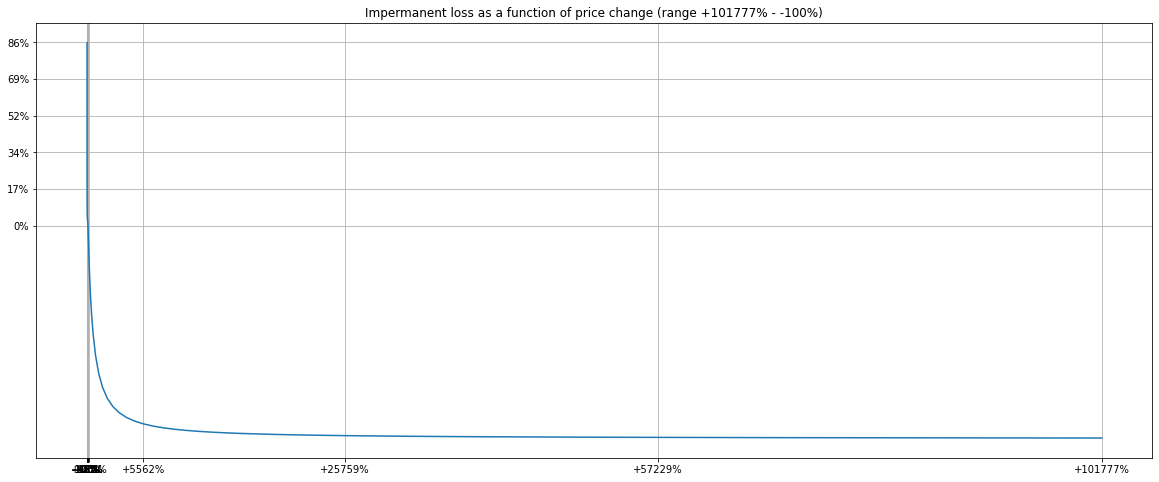

In [2]:
steps = 201
# price_min = 0.2
# price_max = 5
trade_size_min, trade_size_max = -1000000, 1000000
step_factor = (trade_size_max / trade_size_min) ** (1 / (steps - 1))
trade_sizes = [trade_size_min + i * (trade_size_max - trade_size_min) / steps for i in range(steps)]
# [-trade_size_min * step_factor ** i for i in range(steps)][::-1] + [trade_size_min * step_factor ** i for i in range(steps)]
events = []

for trade_size in trade_sizes:

    events.append(
        run.run(initial_state, time_steps=1, silent=True)[-1].execute_swap(
            pool_id='stableswap',
            agent_id='Trader',
            tkn_sell='USDA' if trade_size > 0 else 'USDB',
            tkn_buy='USDB' if trade_size > 0 else 'USDA',
            sell_quantity=max(abs(trade_size), 0),
        )
    )

usda_prices = [
    1 / event.pools['stableswap'].spot_price
    for event in events
]

for event in events:
    StableSwapPoolState.execute_remove_liquidity(
        state=event.pools['stableswap'],
        agent=event.agents['LP'],
        shares_removed=event.agents['LP'].holdings['stableswap'],
        tkn_remove='USDA'
    )

asset_value = [
    value_assets(prices={'USDA': usda_prices[i]}, assets=event.agents['LP'].holdings)
    for i, event in enumerate(events)
]

deposit_value = [
    value_assets(prices={'USDA': usda_prices[i]}, assets=initial_state.agents['LP'].holdings)
    for i, event in enumerate(events)
]

# agent_funds = [
#     event.cash_out(event.agents['LP'])
#     for i, event in enumerate(events)
# ]

impermanent_loss = [
    asset_value[i] / deposit_value[i] - 1
    for i, event in enumerate(events)
]

agent_value = [
    value_assets(
        prices={
            'USDA': usda_prices[i]
        }, 
        assets=initial_state.agents['LP'].holdings
    ) - 1
    for i in range(len(events))
]

plt.figure(figsize=(20, 8))
# plt.xscale('symlog')

# clear default ticks
for t in plt.gca().xaxis.get_minor_ticks():
    t.set_visible(False)

graph_length = len(events)
x_points = 16
x_step = (graph_length - 1) / (x_points - 1)
x_ticks = [usda_prices[int(x_step * i)] for i in range(x_points)]
x_labels = []
for t in x_ticks:
    if t < 1:
        x_labels.append(f'-{round((1 - t) * 100)}%')
    else:
        x_labels.append(f'+{round((t - 1) * 100)}%')
plt.xticks(x_ticks, x_labels)

y_min = round(impermanent_loss[-1] * 100) / 100
y_points = 6
y_step = y_min / (y_points - 1)
y_ticks = [y_min - y_step * i for i in range(y_points)]
y_labels = [f'{round(y * 100)}%' for y in y_ticks]
plt.yticks(y_ticks, y_labels)

plt.grid()
plt.title(f'Impermanent loss as a function of price change (range {x_labels[0]} - {x_labels[-1]})')

# colors = pu.color_gradient(len(events), color1=(255, 128, 0), color2=(0, 0, 255))
# for i in range(len(events)):
plt.plot(usda_prices, impermanent_loss)
# plt.plot(usda_prices, asset_value)
# plt.plot(usda_prices, deposit_value)
# plt.legend([f'{round(weight * 100, 1)}%' for weight in weight_factors])

# plt.figure(figsize=(20, 5))
# plt.plot(range(len(events)), [
#     agent_funds[i] / agent_value[i]
#     for i, event in enumerate(events)
# ])

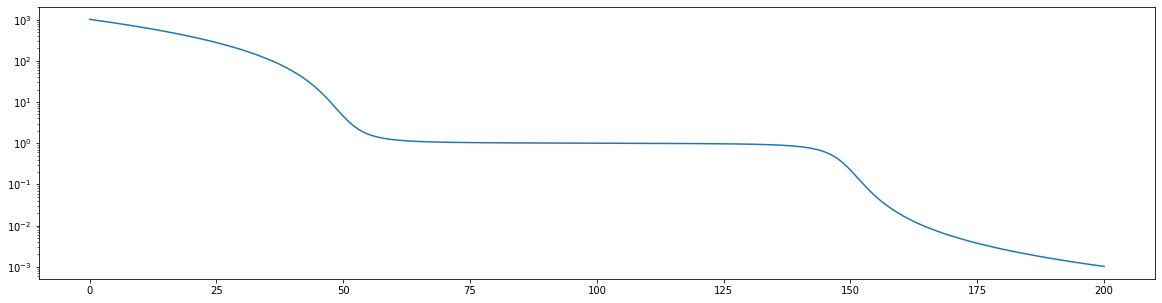

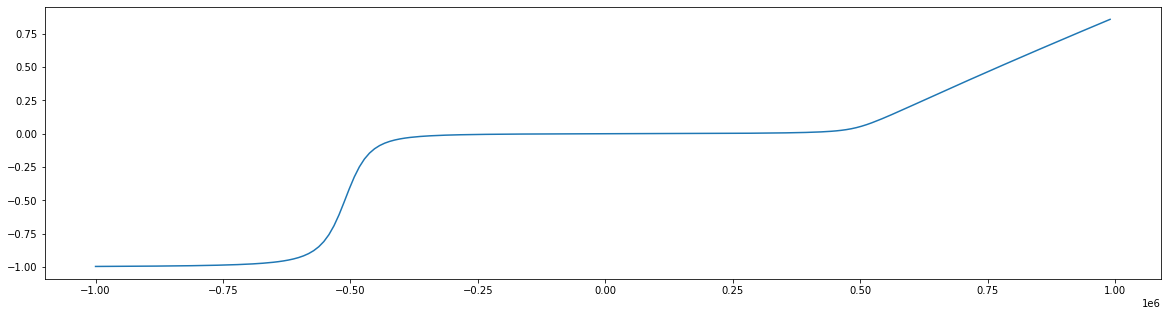

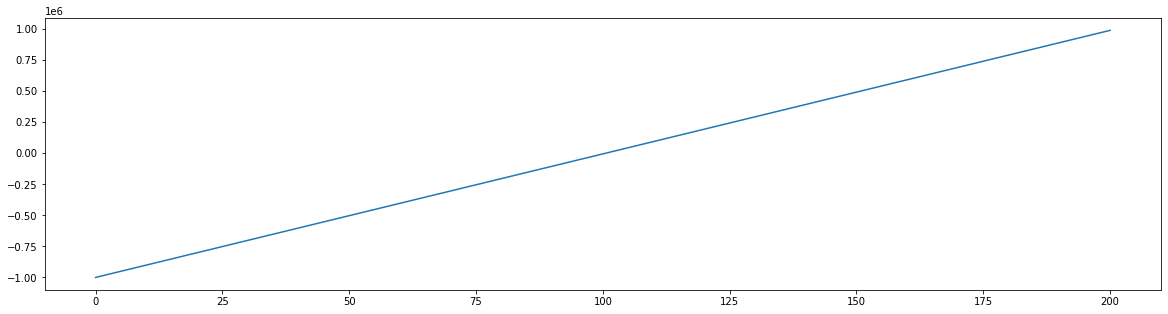

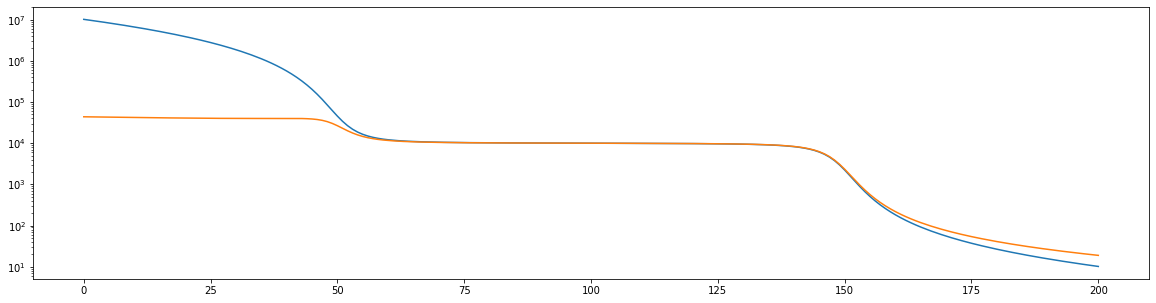

In [3]:
plt.figure(figsize=(20,5))
plt.plot(range(len(events)), usda_prices)
plt.yscale('log')
plt.figure(figsize=(20,5))
plt.plot(trade_sizes, impermanent_loss)
plt.figure(figsize=(20,5))
plt.plot(range(len(events)), trade_sizes)
plt.figure(figsize=(20,5))
plt.plot(range(len(events)), deposit_value)
# plt.figure(figsize=(20,5))
plt.plot(range(len(events)), asset_value)
plt.yscale('log')


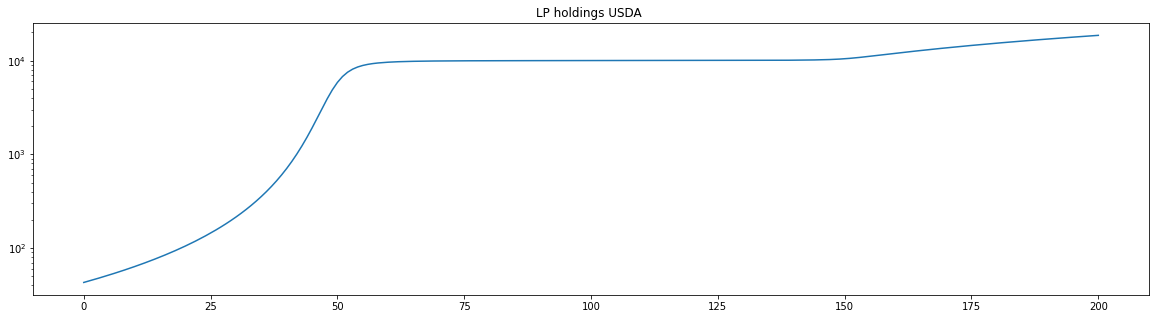

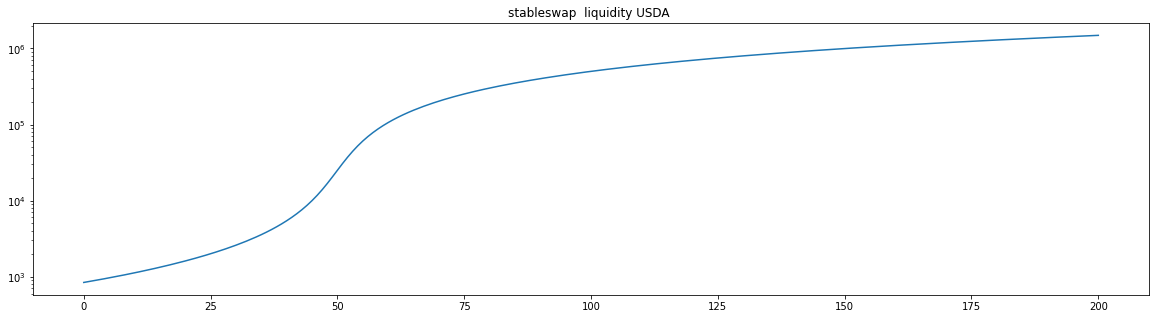

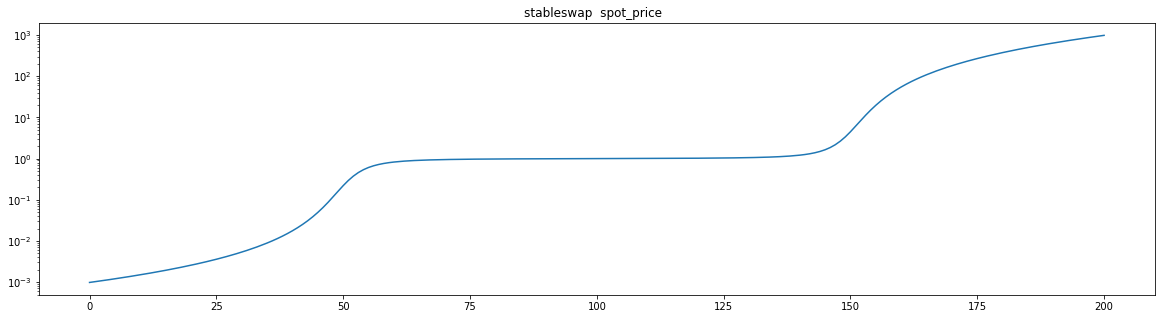

In [4]:
pu.plot(events, agent='LP', prop='holdings', key='USDA')
plt.yscale('log')
pu.plot(events, pool='stableswap', prop='liquidity', key='USDA')
plt.yscale('log')
pu.plot(events, pool='stableswap', prop='spot_price')
plt.yscale('log')

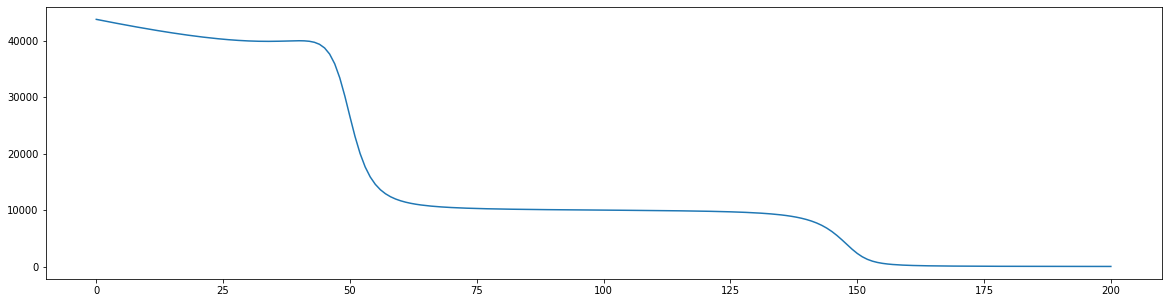

In [5]:
holdings = pu.get_datastream(events, agent='LP', prop='holdings', key='USDA')
price = pu.get_datastream(events, pool='stableswap', prop='spot_price')
plt.figure(figsize=(20, 5))
plt.plot(range(len(events)), [holdings[i] / price[i] for i in range(len(events))])